# This notebook is used to generate the data and analyses of the background section of my master's thesis

In [99]:
# Imports
import numpy
import adaptive_nof1
import pandas
import scipy.stats as stats
import seaborn
import pymc
import arviz
import matplotlib.pyplot as plt
import arviz.labels as azl

In [76]:
# Generate data:
rng = numpy.random.default_rng(42) # Use a seed to be reproducible

n_patients = 10
n_treatments = 2
treatment_sequence = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2]

mean_effect_patients_treatment_1 = rng.normal(1,0.7, size=n_patients)
mean_effect_patients_treatment_2 = rng.normal(0,0.7, size=n_patients)

outcomes_treatment_1 = rng.normal(mean_effect_patients_treatment_1, 1, size=(5, len(mean_effect_patients_treatment_1)))
outcomes_treatment_2 = rng.normal(mean_effect_patients_treatment_2, 1, size=(5, len(mean_effect_patients_treatment_2)))
df = pandas.concat([pandas.DataFrame(outcomes_treatment_1), pandas.DataFrame(outcomes_treatment_2)])
df["t"] = range(1, 11)
df.set_index("t")
df["intervention"] = treatment_sequence

def print_for_latex(array):
    str = ""
    for element in array:
        str += f"{element:.2f}"
        if element != array[-1]:
            str += "& "
        else:
            str += "\\\\"
    print(str)

print(f"Mean effects 1")
print_for_latex(mean_effect_patients_treatment_1)
print(f"Mean effects 2")
print_for_latex(mean_effect_patients_treatment_2)

Mean effects 1
1.21& 0.27& 1.53& 1.66& -0.37& 0.09& 1.09& 0.78& 0.99& 0.40\\
Mean effects 2
0.62& 0.54& 0.05& 0.79& 0.33& -0.60& 0.26& -0.67& 0.61& -0.03\\


In [77]:
df = df[["t", "intervention", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [78]:
# Export the DataFrame to a LaTeX table
latex_table = df.to_latex(index=False, float_format='%.1f')
# Print or save the LaTeX table to a .tex file
print(latex_table)

with open('mt_resources/2-background/background_example_data.tex', 'w') as f:
    f.write(latex_table)

\begin{tabular}{rrrrrrrrrrrr}
\toprule
t & intervention & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\
\midrule
1 & 1 & 1.0 & -0.4 & 2.7 & 1.5 & -0.8 & -0.3 & 1.6 & 1.1 & 1.4 & 0.8 \\
2 & 1 & 3.4 & -0.1 & 1.0 & 0.8 & 0.3 & 1.2 & 1.0 & -0.1 & 0.2 & 1.1 \\
3 & 1 & 2.0 & 0.8 & 0.9 & 1.9 & -0.2 & 0.3 & 2.0 & 1.0 & 1.7 & 0.5 \\
4 & 1 & 1.5 & 0.9 & 0.1 & 1.3 & -0.8 & -0.6 & 0.8 & 2.3 & 0.1 & 1.4 \\
5 & 1 & -0.5 & -0.1 & 1.7 & 2.2 & 0.3 & 0.9 & 0.7 & 0.3 & 1.8 & 0.2 \\
6 & 2 & -0.7 & -0.6 & -0.9 & 1.3 & 0.5 & 0.1 & -0.2 & -0.5 & 1.2 & -0.3 \\
7 & 2 & 1.1 & -0.1 & -0.3 & 0.4 & -0.9 & -0.1 & -0.2 & -0.7 & 1.1 & 0.4 \\
8 & 2 & 1.3 & 0.4 & -0.4 & 0.7 & -1.4 & -2.0 & -1.1 & -1.7 & 1.0 & -0.9 \\
9 & 2 & 0.2 & 1.8 & -0.3 & 1.5 & -0.6 & -0.8 & -0.7 & -1.0 & 1.5 & -1.8 \\
10 & 2 & 1.1 & 0.8 & -0.5 & -0.7 & 0.4 & -1.1 & 0.5 & -0.6 & 2.2 & -0.3 \\
\bottomrule
\end{tabular}



In [79]:
# Plot the posterior of m_{0,0} and m_{0, 1} given the condition on only the data for patient one
n = numpy.array([5, 5])
sigma_squared_0 = numpy.array([1, 1])
sigma_squared = numpy.array([1,1])
sigma_squared_n = 1 / ((n / sigma_squared) + 1 / sigma_squared_0)
mu_0 = numpy.array([0, 0])

means_of_observations = df.groupby("intervention")[0].mean().to_numpy()

mu_n = sigma_squared_n * (mu_0 / sigma_squared_0 + (5 * means_of_observations) / sigma_squared)
print(f"mu_n {mu_n}")
print(f"sigma_squared {sigma_squared_n}")

mu_n [1.2287998  0.49677134]
sigma_squared [0.16666667 0.16666667]


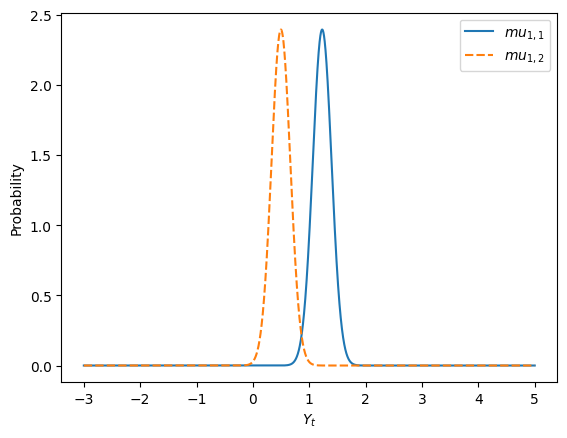

In [80]:
# plot posterior predictive for mu
x = numpy.linspace(-3, 5.0, 10000)
y_0 = stats.norm.pdf(x, mu_n[0], sigma_squared_n[0])
y_1 = stats.norm.pdf(x, mu_n[1], sigma_squared_n[1])
dff = pandas.DataFrame({"$Y_t$": x, "$mu_{1,1}$": y_0, "$mu_{1,2}$": y_1})
dff.set_index("$Y_t$", inplace=True)
seaborn.lineplot(dff)
plt.ylabel("Probability")
plt.savefig("mt_resources/2-background/mean_posteriors.pdf", bbox_inches="tight")

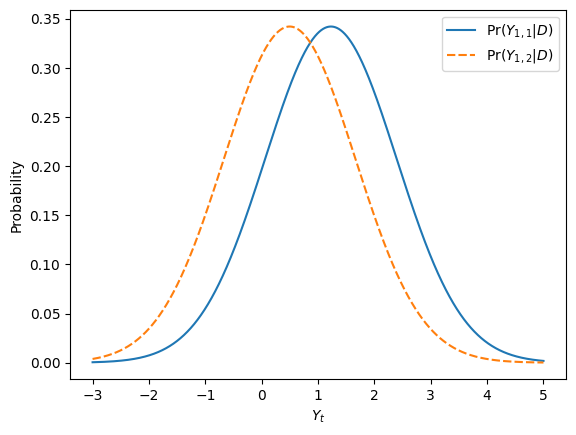

In [81]:
# plot posterior predictive for outcome Pr(x | D)
x = numpy.linspace(-3, 5.0, 10000)
y_0 = stats.norm.pdf(x, mu_n[0], sigma_squared_n[0] + sigma_squared[0])
y_1 = stats.norm.pdf(x, mu_n[1], sigma_squared_n[1] + sigma_squared[0])
dff = pandas.DataFrame({"$Y_t$": x, "$\Pr(Y_{1,1} | D)$": y_0, "$\Pr(Y_{1,2} | D)$": y_1})
dff.set_index("$Y_t$", inplace=True)
seaborn.lineplot(dff)
plt.ylabel("Probability")
plt.savefig("mt_resources/2-background/outcome_posteriors.pdf", bbox_inches="tight")

In [83]:
# Model code for one patient
model = pymc.Model()
with model:
    treatment_index = pymc.MutableData("treatment_index", pymc.intX(df["intervention"]) - 1, dims="observation")
    patient_index = 0
    mu_ik = pymc.Normal("mu_ik", mu=0, sigma=1, dims="treatment", shape=2)
    outcome = pymc.Normal(
        "outcome", mu=mu_ik[treatment_index], observed=df[patient_index], sigma=1, dims="observation", shape=len(df[patient_index]),
    )
    trace = pymc.sample(2000, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.


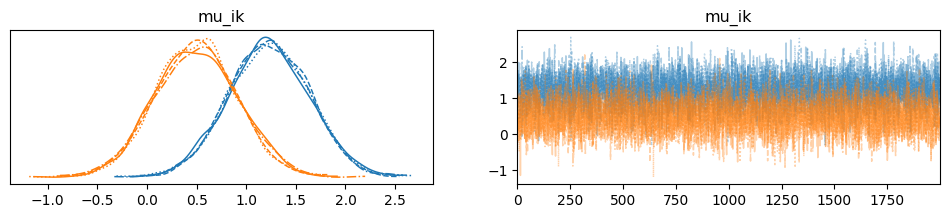

In [95]:
axes = arviz.plot_trace(trace)
plt.savefig("mt_resources/2-background/plot_trace.pdf", bbox_inches="tight")

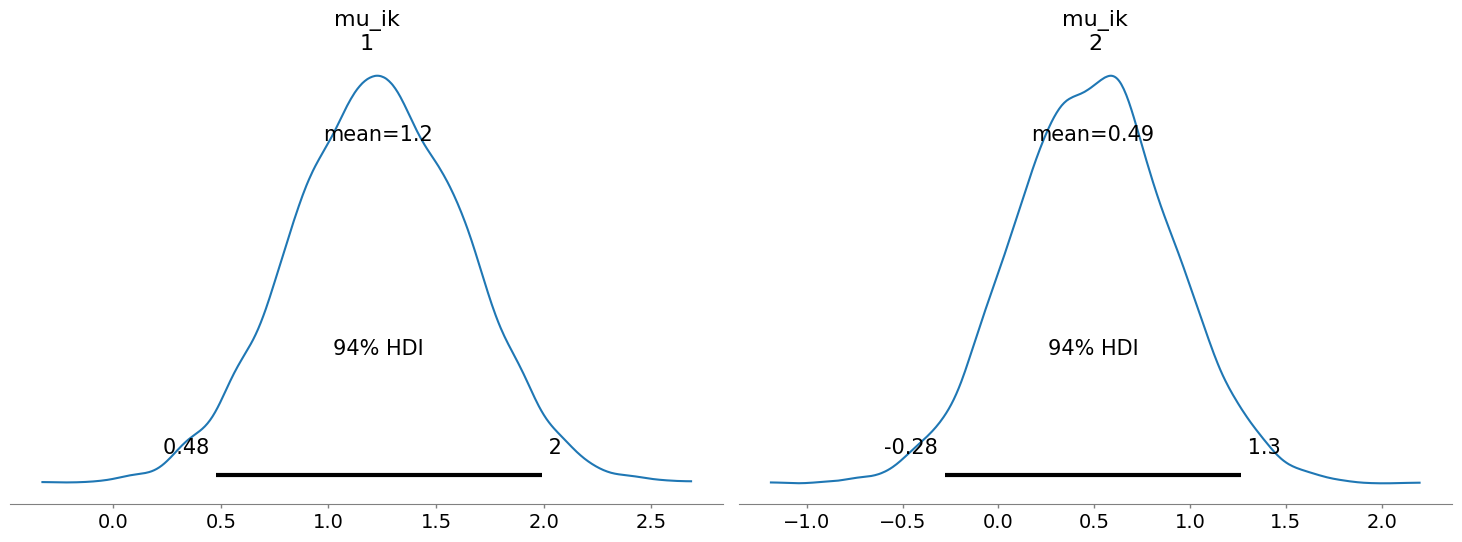

In [104]:
index_plus_one_dict = {i:i+1 for i in range(100)}

coord_map={"treatment": index_plus_one_dict, "patient": index_plus_one_dict}
labeller = azl.MapLabeller(coord_map=coord_map)

coords = {'treatment': [0 , 1]}
arviz.plot_posterior(trace, var_names=('mu_ik'), coords=coords, labeller=labeller)
plt.tight_layout()
plt.savefig("mt_resources/2-background/non-pooled-patient-1.pdf", bbox_inches="tight")

In [11]:
pooled_df = pandas.melt(df, id_vars=["t", "intervention"], var_name="patient_id", value_name='outcome')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


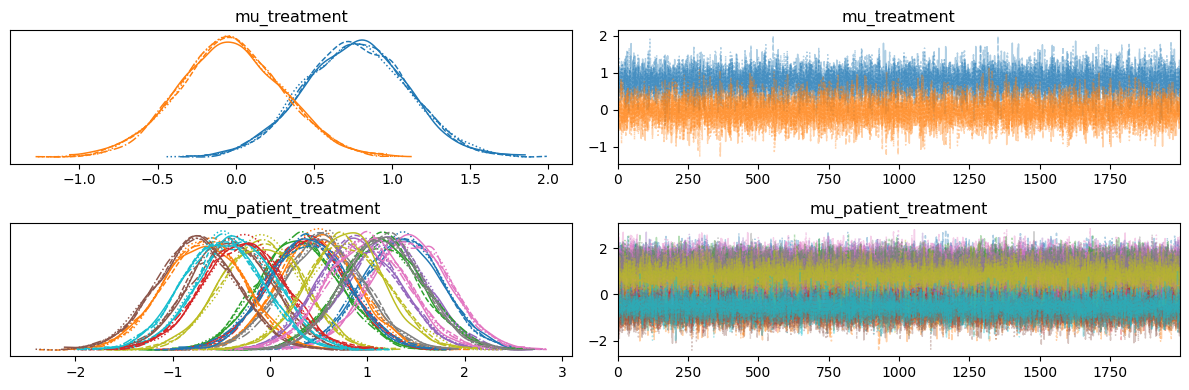

In [15]:
# Pooled mu_ik

# Model code for pooled version
model = pymc.Model()
with model:
    treatment_index = pymc.MutableData("treatment_index", pymc.intX(pooled_df["intervention"]), dims="observation")
    patient_index = pymc.MutableData("patient_index", pymc.intX(pooled_df["patient_id"]), dims="observation")
    mu_treatment = pymc.Normal("mu_treatment", mu=0, sigma=1, dims="treatment", shape=2)
    mu_treatment_patient = pymc.Normal("mu_patient_treatment", mu=mu_treatment, sigma=1, dims=("patient", "treatment"), shape=(10, 2))
    outcome = pymc.Normal(
        "outcome", mu=mu_treatment_patient[patient_index, treatment_index], observed=pooled_df["outcome"], sigma=1, dims="observation", shape=len(pooled_df["outcome"]),
    )
    trace = pymc.sample(2000, progressbar=False)
arviz.plot_trace(trace)
plt.tight_layout()
plt.savefig("mt_resources/2-background/plot_trace_pooled.pdf", bbox_inches="tight")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 4 seconds.


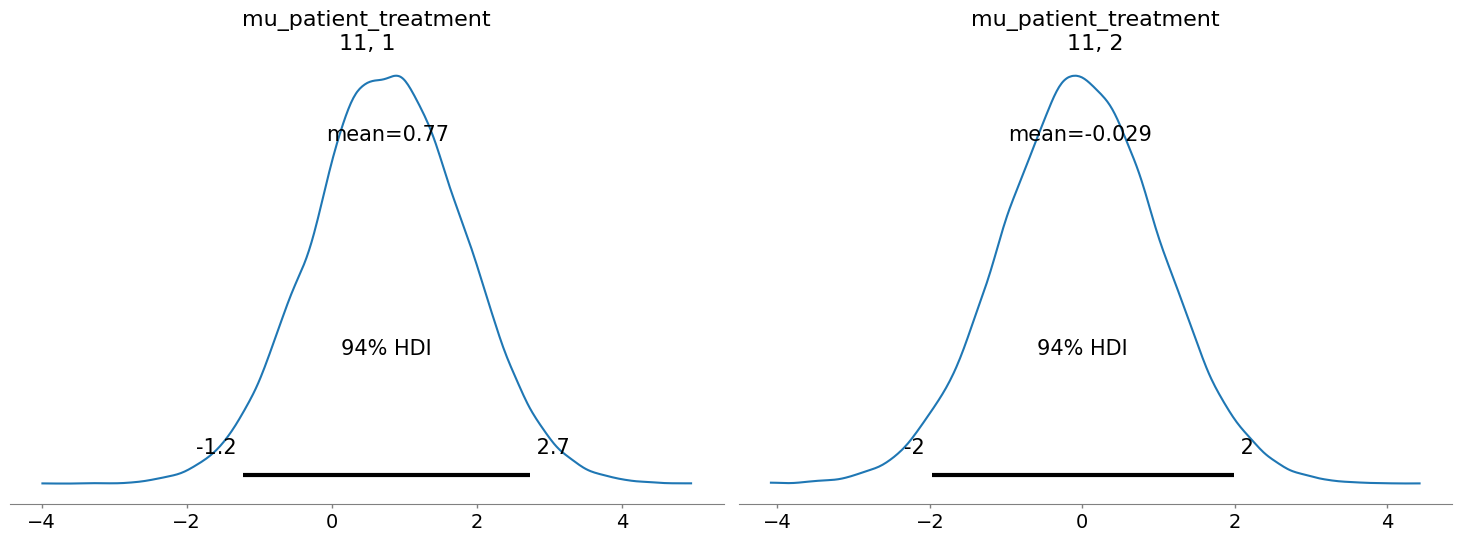

In [137]:
# Patient who is out of sample with data from other patients
model = pymc.Model()
with model:
    treatment_index = pymc.MutableData("treatment_index", pymc.intX(pooled_df["intervention"]), dims="observation")
    patient_index = pymc.MutableData("patient_index", pymc.intX(pooled_df["patient_id"]), dims="observation")
    mu_treatment = pymc.Normal("mu_treatment", mu=0, sigma=1, dims="treatment", shape=2)
    mu_treatment_patient = pymc.Normal("mu_patient_treatment", mu=mu_treatment, sigma=1, dims=("patient", "treatment"), shape=(11, 2))
    outcome = pymc.Normal(
        "outcome", mu=mu_treatment_patient[patient_index, treatment_index], observed=pooled_df["outcome"], sigma=1, dims="observation", shape=len(pooled_df["outcome"]),
    )
    trace = pymc.sample(10000, progressbar=False)
coords = {'treatment': [0 , 1], "patient": [10]}
arviz.plot_posterior(trace, var_names=('mu_patient_treatment'), coords=coords, labeller=labeller)
plt.tight_layout()
plt.savefig("mt_resources/2-background/out-of-sample-pooled-posterior-with-data.pdf", bbox_inches="tight")

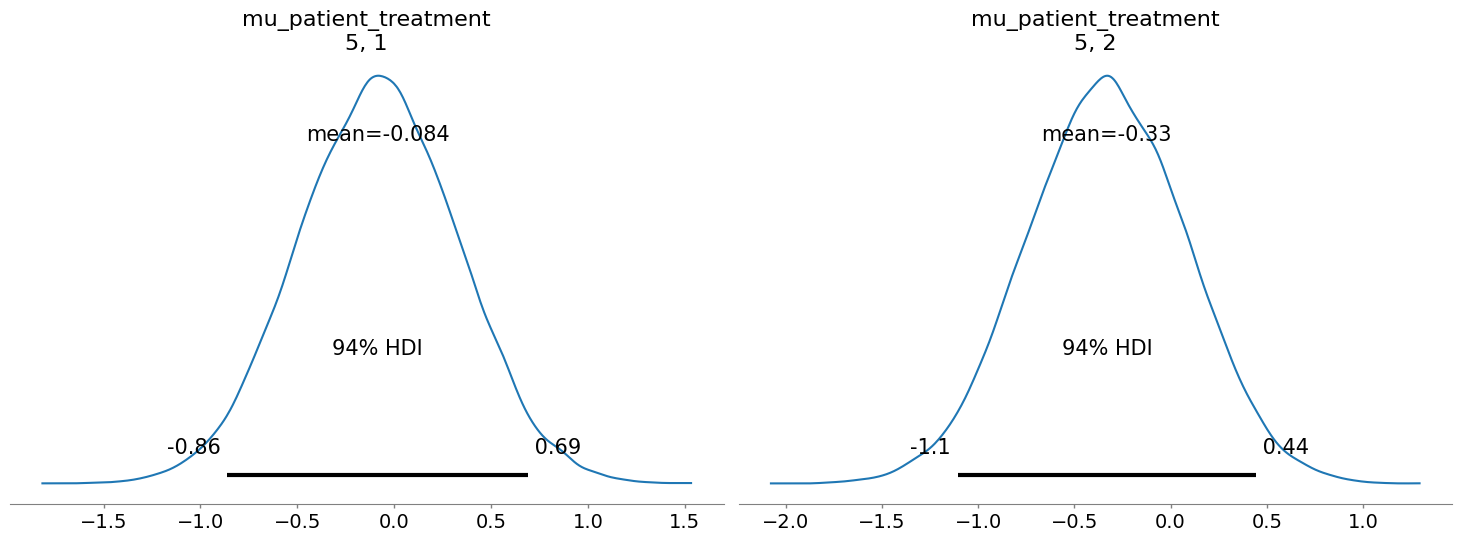

In [138]:
# Patient 5 with data available
coords = {'treatment': [0 , 1], "patient": [4]}
arviz.plot_posterior(trace, var_names=('mu_patient_treatment'), coords=coords, labeller=labeller)
plt.tight_layout()
plt.savefig("mt_resources/2-background/pooled-patient-5-with-data.pdf", bbox_inches="tight")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 5 seconds.


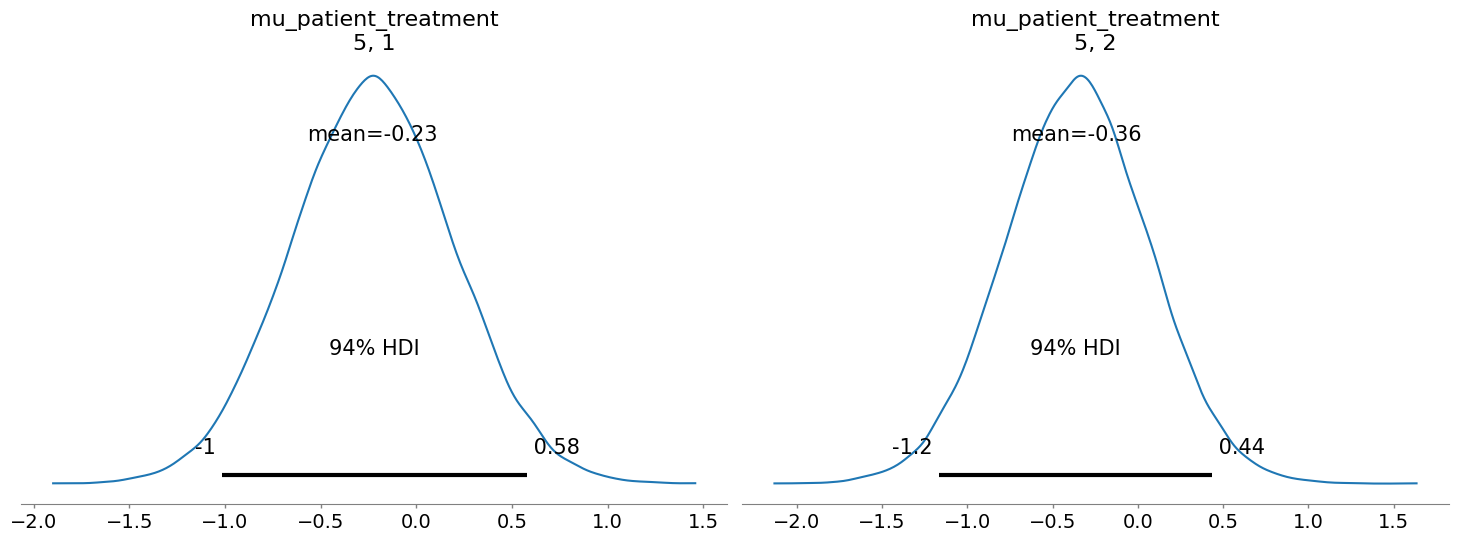

In [136]:
# Patient 1 with no data from other patients
patient_one_df = pooled_df[pooled_df["patient_id"] == 4]
#print(patient_one_df)
model = pymc.Model()
with model:
    treatment_index = pymc.MutableData("treatment_index", pymc.intX(patient_one_df["intervention"]), dims="observation")
    patient_index = pymc.MutableData("patient_index", pymc.intX(patient_one_df["patient_id"]), dims="observation")
    mu_treatment = pymc.Normal("mu_treatment", mu=0, sigma=1, dims="treatment", shape=2)
    mu_treatment_patient = pymc.Normal("mu_patient_treatment", mu=mu_treatment, sigma=1, dims=("patient", "treatment"), shape=(12, 2))
    outcome = pymc.Normal(
        "outcome", mu=mu_treatment_patient[patient_index, treatment_index], observed=patient_one_df["outcome"], sigma=1, dims="observation", shape=len(patient_one_df["outcome"]),
    )
    trace = pymc.sample(10000, progressbar=False)
coords = {'treatment': [0 , 1], "patient": [4]}
arviz.plot_posterior(trace, var_names=('mu_patient_treatment'), coords=coords, labeller=labeller)
plt.tight_layout()
plt.savefig("mt_resources/2-background/pooled-patient-5-no-data.pdf", bbox_inches="tight")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


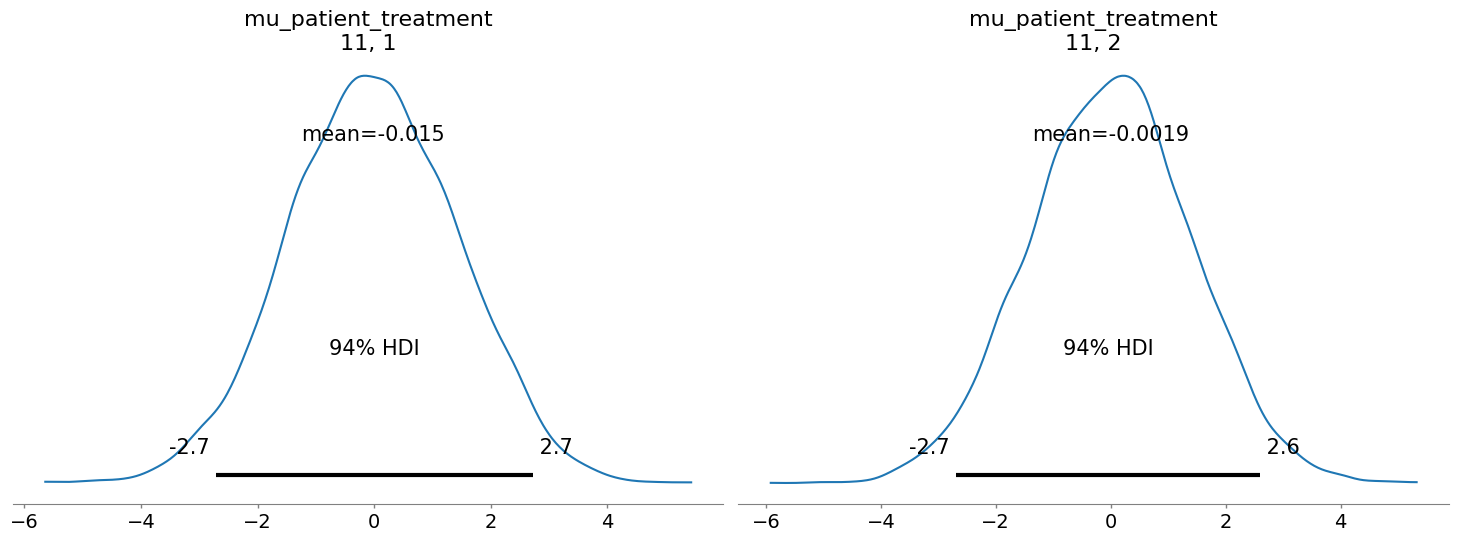

In [112]:
# Patient who is out of sample with no data from other patients
model = pymc.Model()
with model:
    treatment_index = pymc.MutableData("treatment_index", pymc.intX([]), dims="observation")
    patient_index = pymc.MutableData("patient_index", pymc.intX([]), dims="observation")
    mu_treatment = pymc.Normal("mu_treatment", mu=0, sigma=1, dims="treatment", shape=2)
    mu_treatment_patient = pymc.Normal("mu_patient_treatment", mu=mu_treatment, sigma=1, dims=("patient", "treatment"), shape=(11, 2))
    outcome = pymc.Normal(
        "outcome", mu=mu_treatment_patient[patient_index, treatment_index], observed=[], sigma=1, dims="observation", shape=len([]),
    )
    trace = pymc.sample(2000, progressbar=False)
coords = {'treatment': [0 , 1], "patient": [10]}
arviz.plot_posterior(trace, var_names=('mu_patient_treatment'), coords=coords, labeller=labeller)
plt.tight_layout()
plt.savefig("mt_resources/2-background/out-of-sample-pooled-posterior-with-no-data.pdf", bbox_inches="tight")

In [110]:
arviz.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_treatment[0],0.030,1.022,-1.935,1.930,0.029,0.020,1259.0,2010.0,1.0
mu_treatment[1],0.055,0.978,-1.728,1.940,0.027,0.019,1280.0,2425.0,1.0
"mu_patient_treatment[0, 0]",0.020,1.454,-2.635,2.848,0.032,0.023,2047.0,3741.0,1.0
"mu_patient_treatment[0, 1]",0.047,1.386,-2.565,2.635,0.029,0.021,2251.0,3844.0,1.0
"mu_patient_treatment[1, 0]",0.026,1.437,-2.669,2.713,0.033,0.023,1913.0,3775.0,1.0
"mu_patient_treatment[1, 1]",0.046,1.408,-2.665,2.688,0.031,0.022,2053.0,3765.0,1.0
"mu_patient_treatment[2, 0]",0.033,1.418,-2.652,2.658,0.031,0.022,2065.0,3903.0,1.0
"mu_patient_treatment[2, 1]",0.049,1.384,-2.633,2.510,0.029,0.021,2235.0,3871.0,1.0
"mu_patient_treatment[3, 0]",0.035,1.414,-2.774,2.573,0.032,0.023,1969.0,3274.0,1.0
"mu_patient_treatment[3, 1]",0.053,1.389,-2.535,2.673,0.029,0.021,2237.0,3605.0,1.0


In [51]:
# Different posterior options
treatment_0_outcomes  = rng.normal(0,1, size = 5)
treatment_1_outcomes  = rng.normal(1,1, size = 5)
df = pandas.DataFrame({"t": range(10), "intervention": [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 0: [*treatment_0_outcomes, *treatment_1_outcomes]})
df

,t,intervention,0
0,0,0,-1.023497
1,1,0,0.179276
2,2,0,0.219997
3,3,0,1.359188
4,4,0,0.835111
5,5,1,1.356871
6,6,1,2.463303
7,7,1,-0.188763
8,8,1,0.360248
9,9,1,0.073424


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n0'}> <Axes: title={'center': 'mu_ik\n1'}>]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n0'}> <Axes: title={'center': 'mu_ik\n1'}>]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n0'}> <Axes: title={'center': 'mu_ik\n1'}>]


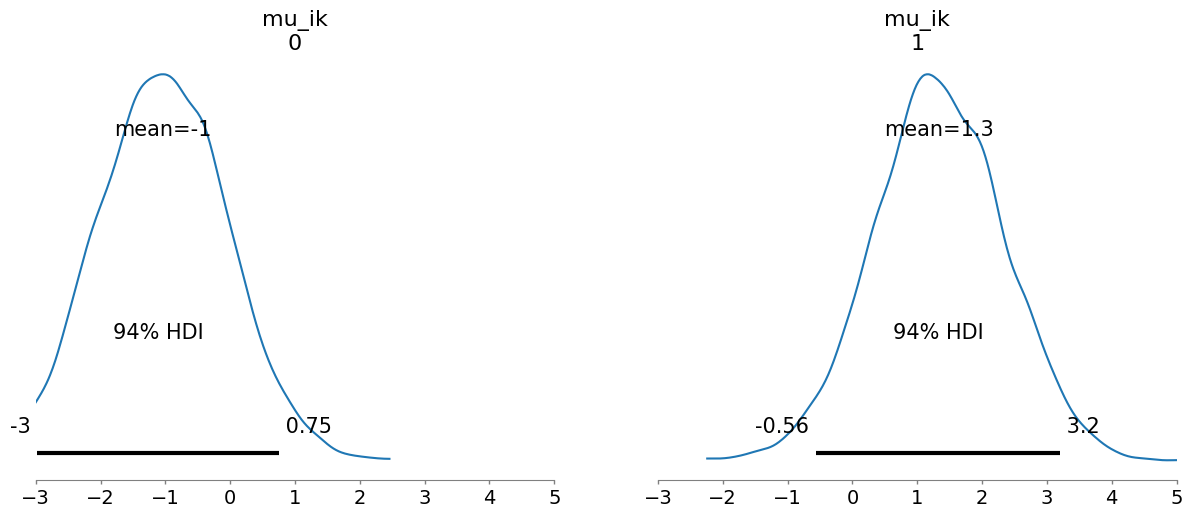

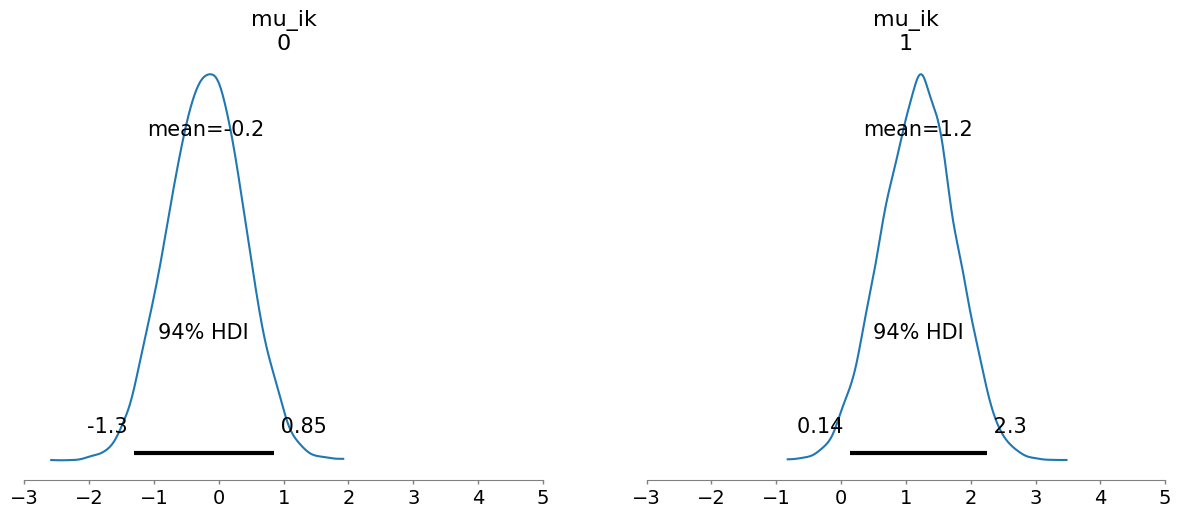

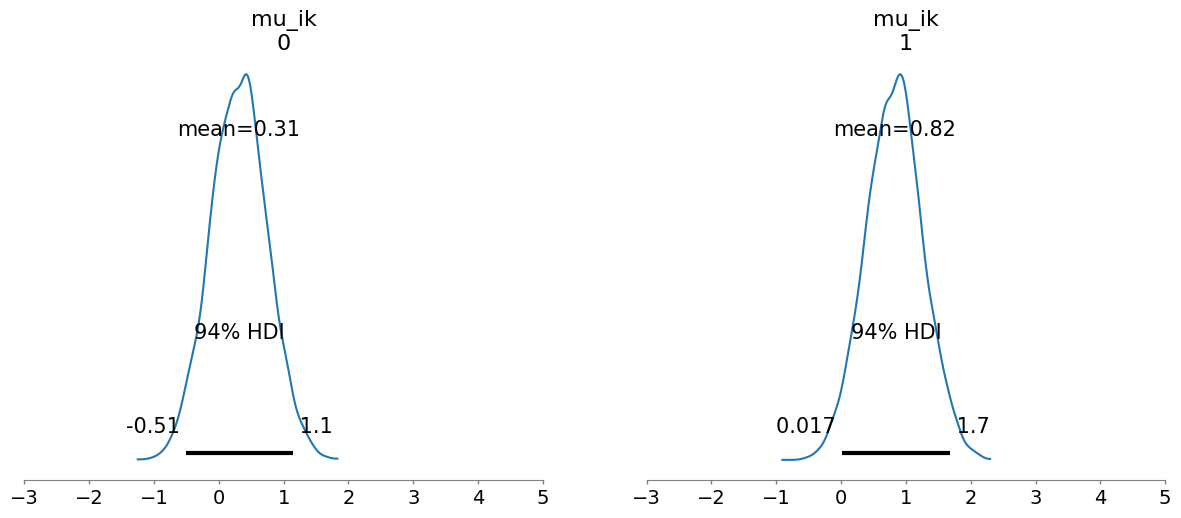

In [52]:
# Wide gaussian
observation_length = [1, 3, 5]
ax = None
for l in observation_length:
    shortened_df = df[df["t"] % 5 < l]
    model = pymc.Model()
    with model:
        treatment_index = pymc.MutableData("treatment_index", pymc.intX(shortened_df["intervention"]), dims="observation")
        patient_index = 0
        mu_ik = pymc.Normal("mu_ik", mu=0, sigma=10, dims="treatment", shape=2)
        outcome = pymc.Normal(
            "outcome", mu=mu_ik[treatment_index], observed=shortened_df[patient_index], sigma=1, dims="observation", shape=len(shortened_df[patient_index]),
        )
        trace = pymc.sample(2000, progressbar=False)
        axes = arviz.plot_posterior(trace)
        print(axes)
        for ax in axes:
            ax.set_xlim(-3,5)

    plt.savefig(f"mt_resources/2-background/priors-wide-gaussian-{l}.pdf", bbox_inches="tight")

In [ ]:
# Narrow gaussian
observation_length = [1, 3, 5]
ax = None
for l in observation_length:
    shortened_df = df[df["t"] % 5 < l]
    model = pymc.Model()
    with model:
        treatment_index = pymc.MutableData("treatment_index", pymc.intX(shortened_df["intervention"]), dims="observation")
        patient_index = 0
        mu_ik = pymc.Normal("mu_ik", mu=0, sigma=0.5, dims="treatment", shape=2)
        outcome = pymc.Normal(
            "outcome", mu=mu_ik[treatment_index], observed=shortened_df[patient_index], sigma=1, dims="observation", shape=len(shortened_df[patient_index]),
        )
        trace = pymc.sample(2000, progressbar=False)
        axes = arviz.plot_posterior(trace)
        print(axes)
        for ax in axes:
            ax.set_xlim(-3,5)
    plt.savefig(f"mt_resources/2-background/priors-narrow-gaussian-{l}.pdf", bbox_inches="tight")

In [ ]:
# Narrow Uniform
observation_length = [1, 3, 5]
ax = None
for l in observation_length:
    shortened_df = df[df["t"] % 5 < l]
    model = pymc.Model()
    with model:
        treatment_index = pymc.MutableData("treatment_index", pymc.intX(shortened_df["intervention"]), dims="observation")
        patient_index = 0
        mu_ik = pymc.Uniform("mu_ik", lower=-0.5, upper=1.5, dims="treatment", shape=2)
        outcome = pymc.Normal(
            "outcome", mu=mu_ik[treatment_index], observed=shortened_df[patient_index], sigma=1, dims="observation", shape=len(shortened_df[patient_index]),
        )
        trace = pymc.sample(2000, progressbar=False)
        axes = arviz.plot_posterior(trace)
        print(axes)
        for ax in axes:
            ax.set_xlim(-3,5)
    plt.savefig(f"mt_resources/2-background/priors-narrow-uniform-{l}.pdf", bbox_inches="tight")

In [ ]:
# Wide Uniform
observation_length = [1, 3, 5]
ax = None
for l in observation_length:
    shortened_df = df[df["t"] % 5 < l]
    model = pymc.Model()
    with model:
        treatment_index = pymc.MutableData("treatment_index", pymc.intX(shortened_df["intervention"]), dims="observation")
        patient_index = 0
        mu_ik = pymc.Uniform("mu_ik", lower=-5, upper=5, dims="treatment", shape=2)
        outcome = pymc.Normal(
            "outcome", mu=mu_ik[treatment_index], observed=shortened_df[patient_index], sigma=1, dims="observation", shape=len(shortened_df[patient_index]),
        )
        trace = pymc.sample(2000, progressbar=False)
        axes = arviz.plot_posterior(trace)
        print(axes)
        for ax in axes:
            ax.set_xlim(-3,5)
    plt.savefig(f"mt_resources/2-background/priors-wide-uniform-{l}.pdf", bbox_inches="tight")